In [1]:
from __future__ import annotations

from typing import Any

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display as ipy_display

import torch
import transformers
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from transformers import Trainer
from transformers import TrainingArguments
from transformers.trainer_utils import EvalPrediction

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}", end="\n\n")
print(f"Torch version: {torch.__version__}")

Using device: cuda

Torch version: 1.13.1+cu116


In [3]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [4]:
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


def compute_metrics(eval_pred: EvalPrediction) -> dict[str, Any]:
    """Compute metrics for the model."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='macro'),
        'recall': recall_score(labels, predictions, average='macro'),
        'f1': f1_score(labels, predictions, average='macro'),
    }

In [5]:
RAW_DATA_FILE = "../../data/reddit_ell_eng_raw_pos.csv"

MARKERS = ['o', 's', 'v', 'p', 'x', 'd', 'h', '8', 'P', '*']
COLORS  = ['#404080', '#a52040', '#7d7dfa', '#d7d7d7', '#ff7f0e',
           '#2ca02c', '#1f77b4', '#9467bd', '#8c564b', '#e377c2']

PARMS = {
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 1e-6,
    'seed': 42,
    'max_length': 512,
}

all_results = pd.DataFrame()

In [6]:
df = pd.read_csv(RAW_DATA_FILE, encoding='utf-8')

df, labels = encode_labels(df, 'label')

X = df['text']
y = df['label']

gss_1 = GroupShuffleSplit(n_splits=5, test_size=0.2)
train_idx, test_idx = next(gss_1.split(X, y, groups=df['user_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

gss_2 = GroupShuffleSplit(n_splits=5, test_size=0.5)
val_idx, test_idx = next(gss_2.split(X_test, y_test, groups=df['user_id'].iloc[test_idx]))
X_val, X_test = X_test.iloc[val_idx], X_test.iloc[test_idx]
y_val, y_test = y_test.iloc[val_idx], y_test.iloc[test_idx]

print(f"{X_train.shape=}, {X_test.shape=}")
print(f"{y_train.shape=}, {y_test.shape=}")
print(f"{X_val.shape=}, {y_val.shape=}", end="\n\n")

X_train.shape=(7606,), X_test.shape=(1394,)
y_train.shape=(7606,), y_test.shape=(1394,)
X_val.shape=(924,), y_val.shape=(924,)



In [7]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = transformers.DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)

train_dataset = RedditDataset(train_encodings, y_train.tolist())
test_dataset = RedditDataset(test_encodings, y_test.tolist())
val_dataset = RedditDataset(val_encodings, y_val.tolist())


# add dropout and early stopping
model.config.dropout = 0.9
early_stopping = transformers.EarlyStoppingCallback(early_stopping_patience=5)

training_args = transformers.TrainingArguments(
    output_dir=f'../results/reports/{model_name}',
    num_train_epochs=PARMS['epochs'],
    learning_rate=PARMS['learning_rate'],
    per_device_train_batch_size=PARMS['batch_size'],
    per_device_eval_batch_size=PARMS['batch_size'],
    evaluation_strategy='epoch',
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs/distilbert',
    logging_steps=len(train_dataset) // PARMS['batch_size'],
    log_level='error',
    disable_tqdm=False,
    seed=PARMS['seed'],
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[early_stopping],
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

  0%|          | 0/11900 [00:00<?, ?it/s]

{'loss': 0.6914, 'learning_rate': 4.7399999999999993e-07, 'epoch': 1.0}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.6892393231391907, 'eval_accuracy': 0.5270562770562771, 'eval_precision': 0.6065718163703397, 'eval_recall': 0.5521184445909048, 'eval_f1': 0.471740964840556, 'eval_runtime': 8.6919, 'eval_samples_per_second': 106.306, 'eval_steps_per_second': 3.336, 'epoch': 1.0}
{'loss': 0.6576, 'learning_rate': 9.479999999999999e-07, 'epoch': 1.99}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.6022336483001709, 'eval_accuracy': 0.7716450216450217, 'eval_precision': 0.779293564697225, 'eval_recall': 0.7769466151963091, 'eval_f1': 0.771527008736311, 'eval_runtime': 8.8204, 'eval_samples_per_second': 104.757, 'eval_steps_per_second': 3.288, 'epoch': 2.0}
{'loss': 0.5155, 'learning_rate': 9.814912280701754e-07, 'epoch': 2.99}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.4814242720603943, 'eval_accuracy': 0.7803030303030303, 'eval_precision': 0.7899300505905409, 'eval_recall': 0.7862489407777045, 'eval_f1': 0.7800864075222613, 'eval_runtime': 9.4751, 'eval_samples_per_second': 97.519, 'eval_steps_per_second': 3.061, 'epoch': 3.0}
{'loss': 0.4362, 'learning_rate': 9.60701754385965e-07, 'epoch': 3.98}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.44872352480888367, 'eval_accuracy': 0.7954545454545454, 'eval_precision': 0.7991251064791065, 'eval_recall': 0.7992138216740421, 'eval_f1': 0.7954543058768411, 'eval_runtime': 10.2728, 'eval_samples_per_second': 89.946, 'eval_steps_per_second': 2.823, 'epoch': 4.0}
{'loss': 0.4102, 'learning_rate': 9.399122807017544e-07, 'epoch': 4.98}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.4490605890750885, 'eval_accuracy': 0.7911255411255411, 'eval_precision': 0.7981525092042854, 'eval_recall': 0.7962197533188965, 'eval_f1': 0.7910548139573301, 'eval_runtime': 8.9623, 'eval_samples_per_second': 103.099, 'eval_steps_per_second': 3.236, 'epoch': 5.0}
{'loss': 0.3948, 'learning_rate': 9.191228070175438e-07, 'epoch': 5.97}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.4711972177028656, 'eval_accuracy': 0.79004329004329, 'eval_precision': 0.805191167094917, 'eval_recall': 0.7974672818002071, 'eval_f1': 0.7894751677095666, 'eval_runtime': 8.7103, 'eval_samples_per_second': 106.082, 'eval_steps_per_second': 3.329, 'epoch': 6.0}
{'loss': 0.3804, 'learning_rate': 8.983333333333332e-07, 'epoch': 6.97}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.4804302752017975, 'eval_accuracy': 0.7846320346320347, 'eval_precision': 0.8018579234972678, 'eval_recall': 0.7925571980039544, 'eval_f1': 0.7838662546385488, 'eval_runtime': 8.7001, 'eval_samples_per_second': 106.206, 'eval_steps_per_second': 3.333, 'epoch': 7.0}
{'loss': 0.3645, 'learning_rate': 8.775438596491228e-07, 'epoch': 7.97}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.48024800419807434, 'eval_accuracy': 0.7824675324675324, 'eval_precision': 0.7996138433515483, 'eval_recall': 0.7903822615572922, 'eval_f1': 0.781694056192705, 'eval_runtime': 8.8303, 'eval_samples_per_second': 104.64, 'eval_steps_per_second': 3.284, 'epoch': 8.0}
{'loss': 0.3586, 'learning_rate': 8.567543859649122e-07, 'epoch': 8.96}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.4840635061264038, 'eval_accuracy': 0.775974025974026, 'eval_precision': 0.7928816029143898, 'eval_recall': 0.7838574522173054, 'eval_f1': 0.7751774608551738, 'eval_runtime': 8.6229, 'eval_samples_per_second': 107.157, 'eval_steps_per_second': 3.363, 'epoch': 9.0}
{'train_runtime': 1869.2578, 'train_samples_per_second': 203.45, 'train_steps_per_second': 6.366, 'train_loss': 0.4670970053677243, 'epoch': 9.0}


TrainOutput(global_step=2142, training_loss=0.4670970053677243, metrics={'train_runtime': 1869.2578, 'train_samples_per_second': 203.45, 'train_steps_per_second': 6.366, 'train_loss': 0.4670970053677243, 'epoch': 9.0})

In [8]:
trainer.evaluate()
trainer.state.save_to_json(f'../results/reports/{model_name}/trainer_state.json')

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

y_pred_metrics:


,test_loss,test_accuracy,test_precision,test_recall,test_f1,test_runtime,test_samples_per_second,test_steps_per_second
0,0.446795,0.791248,0.77664,0.796784,0.781322,12.8572,108.422,3.422


Log history:


,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.6914,4.740000e-07,1.00,237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.00,238,0.689239,0.527056,0.606572,0.552118,0.471741,8.6919,106.306,3.336,NaN,NaN,NaN,NaN,NaN
2,0.6576,9.480000e-07,1.99,474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.00,476,0.602234,0.771645,0.779294,0.776947,0.771527,8.8204,104.757,3.288,NaN,NaN,NaN,NaN,NaN
4,0.5155,9.814912e-07,2.99,711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,3.00,714,0.481424,0.780303,0.789930,0.786249,0.780086,9.4751,97.519,3.061,NaN,NaN,NaN,NaN,NaN
6,0.4362,9.607018e-07,3.98,948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,4.00,952,0.448724,0.795455,0.799125,0.799214,0.795454,10.2728,89.946,2.823,NaN,NaN,NaN,NaN,NaN
8,0.4102,9.399123e-07,4.98,1185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,5.00,1190,0.449061,0.791126,0.798153,0.796220,0.791055,8.9623,103.099,3.236,NaN,NaN,NaN,NaN,NaN


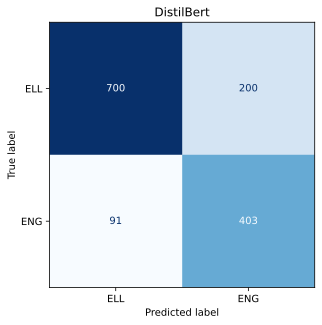

              precision    recall  f1-score   support

         ELL       0.88      0.78      0.83       900
         ENG       0.67      0.82      0.73       494

    accuracy                           0.79      1394
   macro avg       0.78      0.80      0.78      1394
weighted avg       0.81      0.79      0.79      1394



,precision,recall,f1-score,support,maxlen
ELL,0.884956,0.777778,0.827912,900.000000,none
ENG,0.668325,0.815789,0.734731,494.000000,none
accuracy,0.791248,0.791248,0.791248,0.791248,none
macro avg,0.776640,0.796784,0.781322,1394.000000,none
weighted avg,0.808187,0.791248,0.794891,1394.000000,none


In [9]:
y_pred = trainer.predict(test_dataset)
y_pred_metrics = y_pred.metrics
print("y_pred_metrics:")
ipy_display(pd.DataFrame(y_pred_metrics, index=[0]))

logs = pd.DataFrame(trainer.state.log_history)
print("Log history:")
ipy_display(logs)

y_preds = np.argmax(y_pred.predictions, axis=1)
y_true = y_test.tolist()

cm = confusion_matrix(y_true, y_preds)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=labels).plot(colorbar=False, cmap='Blues')
plt.title(f"{model.__class__.__name__.removesuffix('ForSequenceClassification')}")
plt.show();

report = classification_report(y_true, y_preds, target_names=labels, output_dict=True)
print(classification_report(y_true, y_preds, target_names=labels))

results = pd.DataFrame(report).transpose()
results['maxlen'] = 'none'
ipy_display(results)

all_results = pd.concat([all_results, results])

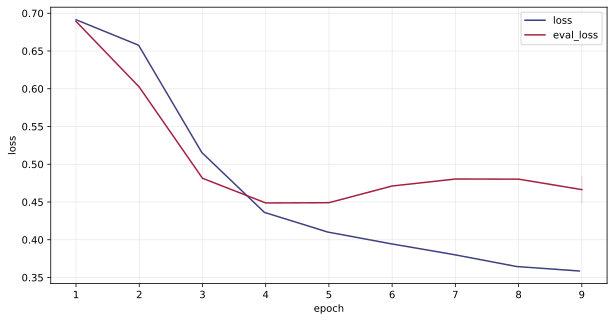

In [10]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=logs, x='epoch', y='loss', color=COLORS[0], label='loss', zorder=2)
sns.lineplot(data=logs, x='epoch', y='eval_loss', color=COLORS[1], label='eval_loss', zorder=2)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(alpha=0.25, zorder=0)
plt.legend()
plt.show();

In [11]:
# Error analysis

df = pd.DataFrame({'text': X_test.tolist(), 'true': y_true, 'pred': y_preds})
df['correct'] = df['true'] == df['pred']
df['correct'] = df['correct'].map({True: 'correct', False: 'incorrect'})
df['true'] = df['true'].map({0: 'ELL', 1: 'ENG'})
df['pred'] = df['pred'].map({0: 'ELL', 1: 'ENG'})
df

,text,true,pred,correct
0,> I bet even you ' v personally not taken a va...,ELL,ELL,correct
1,Even if we accept what you 're suggesting and ...,ELL,ELL,correct
2,Because : 0 ) Most Greeks ( 00 % ) are wage ea...,ELL,ELL,correct
3,> Nor am I interested in making such a claim I...,ELL,ELL,correct
4,yeah they raised the price of heating oil by 0...,ELL,ELL,correct
...,...,...,...,...
1389,China has resorted at this point to artificial...,ENG,ENG,correct
1390,But at the same time May ca n't just come out ...,ENG,ENG,correct
1391,> Frankfurt is in prime position to become the...,ENG,ENG,correct
1392,It was a design choice to cut down on weight u...,ENG,ENG,correct


In [12]:
wrong_preds = df[df['correct'] == 'incorrect'] # only show incorrect predictions
wrong_preds

,text,true,pred,correct
11,"So are these : ** Austria-Hungary ( 0000 , 000...",ELL,ENG,incorrect
14,"> Automation or automatic control , is the use...",ELL,ENG,incorrect
18,"We have fire-fighting vehicles without tires ,...",ELL,ENG,incorrect
22,I 'm no fucking Prime Minister nor do I have 0...,ELL,ENG,incorrect
26,"Imagine having a deed - and I shit you not , t...",ELL,ENG,incorrect
...,...,...,...,...
1365,* Using tons of * Tu Quoque * rather than actu...,ENG,ELL,incorrect
1367,"Nope , I have never seen that law before : / I...",ENG,ELL,incorrect
1372,The Parties are n't divided right now because ...,ENG,ELL,incorrect
1382,> a conflict we had no interest If Romania rea...,ENG,ELL,incorrect
